In [5]:
# librarires ---- 

import pandas as pd
import numpy as np
import yfinance as yf
import random
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
plt.style.use('ggplot')
%matplotlib inline


class Ticker():
    # initialization ----
    def __init__(self, ticker_name, start_date):
        self.ticker = ticker_name
        self.start = start_date
        self.data = yf.download(ticker_name, start_date)
        self.annual_return = self.annual_return()
        self.annual_volatility = self.annual_volatility()

    def annual_return(self):
        data = self.data
        days = len(data)
        annual_return = ((data['Adj Close'][-1]/data['Adj Close'][0])**(252/days)-1)*100
        return annual_return
    
    def annual_volatility(self):
        data = self.data
        data['total_returns'] = data['Adj Close'].pct_change()
        annual_volatility = data.total_returns.std() * np.sqrt(252) * 100
        return annual_volatility
    
    # methods ----
    
    # visualizes close price over time
    def vis_close_price(self):
        data = self.data
        data['Close'].plot(figsize=(15,7))
        plt.ylabel('Close Price')
        plt.title('{} Close Price'.format(self.ticker))
        plt.show()
        
    # adds trading_signal column to data when called by trade_return, trade_volatility, or vis_trade_return
    def MACD(self):
        data = self.data
        data['12d_EMA'] = data.Close.ewm(span=12, adjust=False).mean()
        data['26d_EMA'] = data.Close.ewm(span=26, adjust=False).mean()
        data['macd'] = data['12d_EMA']- data['26d_EMA'] 
        data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()
        data['trading_signal'] = 0
        data.loc[(data['macd'] > data['macdsignal']) & (data['macd'].shift(1) <= data['macdsignal'].shift(1)), 'trading_signal'] = 1
        data.loc[(data['macd'] < data['macdsignal']) & (data['macd'].shift(1) >= data['macdsignal'].shift(1)), 'trading_signal'] = -1
        return data
    
    # adds trading_signal column to data when called by trade_return, trade_volatility, or vis_trade_return adds trading_signal column to data when called
    def SMA(self):
        data = self.data
        data['50d_SMA'] = data.Close.rolling(window=50).mean()
        data['200d_SMA'] = data.Close.rolling(window=200).mean()
        data['trading_signal'] = 0
        data.loc[(data['50d_SMA'] > data['200d_SMA']) & (data['50d_SMA'].shift(1) <= data['200d_SMA'].shift(1)), 'trading_signal'] = 1
        data.loc[(data['50d_SMA'] < data['200d_SMA']) & (data['50d_SMA'].shift(1) >= data['200d_SMA'].shift(1)), 'trading_signal'] = -1
        return data
    
    # helper function for RSI
    def calc_RSI (self, time_window=14):
        data = self.data['Close']
        diff = data.diff(1).dropna()       
        up_chg = 0 * diff
        down_chg = 0 * diff
        up_chg[diff > 0] = diff[diff>0]
        down_chg[diff < 0] = diff[diff < 0]
        up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
        down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()

        rs = abs(up_chg_avg/down_chg_avg)
        rsi = 100 - 100/(1+rs)
        return rsi


    # adds trading_signal column to data when called by trade_return, trade_volatility, or vis_trade_return
    def RSI(self, window=14):
        data = self.data
        data['RSI'] = self.calc_RSI()
        data['trading_signal'] = 0
        data.loc[data['RSI'] < 30, 'trading_signal'] = 1
        data.loc[data['RSI'] > 70, 'trading_signal'] = -1
        return data
    
    def JOE(self, window=14):
        
        

        
        data = self.data
        
        data['RSI'] = self.calc_RSI()
        data['vol_change'] = data['Volume'].pct_change()
        data.dropna()
        data['vol_change'] = data['vol_change'].replace(np.inf, 3000000)
        column = data['vol_change']
        standardized_column = scale(column)
        data['vol_change'] = standardized_column

        data['trading_signal'] = 0
        
        
        data.loc[(
            (data['RSI'] < 30) &
            (data['vol_change'] >= 0.5),
            'trading_signal'
        )] = 1
        data.loc[(
            (data['RSI'] > 70) &
            (data['vol_change'] >= 0.5),
            'trading_signal'
        )] = 1
        return data
    
    # outputs annual return for inputted model method
    def trade_return(self, model):
        model_func = getattr(self, model)
        data = model_func()
        data['returns'] = data.Close.pct_change()
        data['trade_returns'] = data.returns * data.trading_signal.shift(1)
        cumulative_trade_returns = (data.trade_returns + 1).cumprod()
        days = len(cumulative_trade_returns)
        annual_returns = (cumulative_trade_returns.iloc[-1]**(252/days) - 1)*100
        return annual_returns
    
    # outputs annual volatility for inputted model method
    def trade_volatility(self, model):
        model_func = getattr(self, model)
        data = model_func()
        data['returns'] = data.Close.pct_change()
        data['trade_returns'] = data.returns * data.trading_signal.shift(1)
        annual_volatility = data.trade_returns.std() * np.sqrt(252) * 100
        return annual_volatility

    # visualizes cumulative return over time for inputted model method
    def vis_trade_return(self, model):
        model_func = getattr(self, model)
        data = model_func()
        data['returns'] = data.Close.pct_change()
        data['trade_returns'] = data.returns * data.trading_signal.shift(1)
        cumulative_trade_returns = (data.trade_returns + 1).cumprod()
        cumulative_trade_returns.plot(figsize=(15,7))
        plt.ylabel('Cumulative Returns')
        plt.title('Cumulative Returns of {} Strategy on {}'.format(model, self.ticker))
        plt.show()
    
    
    # summary ----
    
    # summarizes return and volatility for a list of models
    def sum_table(self, model_lst):

        # create table with columns
        myTable = pd.DataFrame(columns = ["Strategy", "Annualized Return (%)", "Annualized Volatility (%)"])

        # add first row (investment) 
        myTable = pd.concat(
            [myTable,
            pd.DataFrame(
                [["Investment", round(self.annual_return, 1), round(self.annual_volatility, 1)]],
                columns = ["Strategy", "Annualized Return (%)", "Annualized Volatility (%)"],
            )], 
            ignore_index = True)

        # add the rest of the strategies as rows
        for i, model in enumerate(model_lst):
            myTable = pd.concat(
                [myTable,
                pd.DataFrame(
                    [[model, round(self.trade_return(model), 1), round(self.trade_volatility(model), 1)]],
                    columns = ["Strategy", "Annualized Return (%)", "Annualized Volatility (%)"],
                    )],
                ignore_index = True)
        return myTable

    # summarizes return and volatility for a list of models and plots an efficient frontier graph
    def efficient_front(self, model_lst):
        # load sum_table
        myTable = self.sum_table(model_lst)
        # plot
        plt.figure(figsize=(15, 7))
        plt.scatter(myTable['Annualized Volatility (%)'], myTable['Annualized Return (%)'])
        plt.xlabel('Annualized Volatility (%)')
        plt.ylabel('Annualized Return (%)')
        plt.title('Efficient Frontier for {} from {}'.format(self.ticker, self.start))
        # annotate points
        for i, label in enumerate(myTable['Strategy']):
            plt.annotate(label, (myTable['Annualized Volatility (%)'][i], myTable['Annualized Return (%)'][i]))
        return myTable
        plt.show()


    # summarizes visualizations of close price and cumulative return over time for a list of models
    def sum_vis(self, model_lst):
        # visualize the investment strategy
        self.vis_close_price()

        # visualize the rest of the strategies
        for i, model in enumerate(model_lst):
            self.vis_trade_return(model)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_3148/765235474.py:133: RuntimeWarning: invalid value encountered in double_scalars
  annual_returns = (cumulative_trade_returns.iloc[-1]**(252/days) - 1)*100
/var/folders/h5/nb6dpjws5_31tkqzms_p18gr0000gn/T/ipykernel_3148/765235474.py:133: RuntimeWarning: invalid value encountered in double_scalars
  annual_returns = (cumulative_trade_returns.iloc[-1]**(252/days) - 1)*100


[*********************100%***********************]  1 of 1 completed


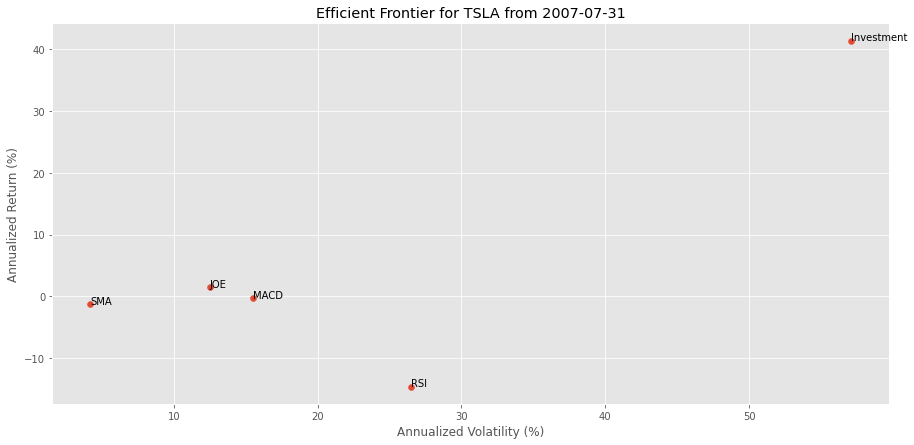

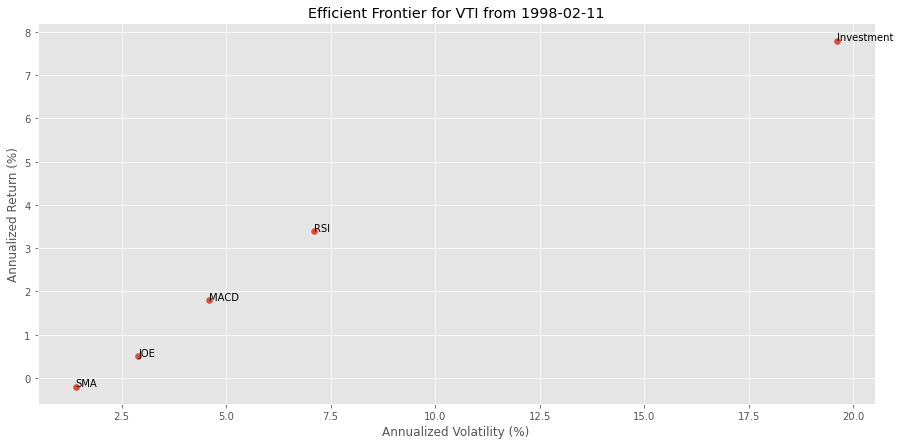

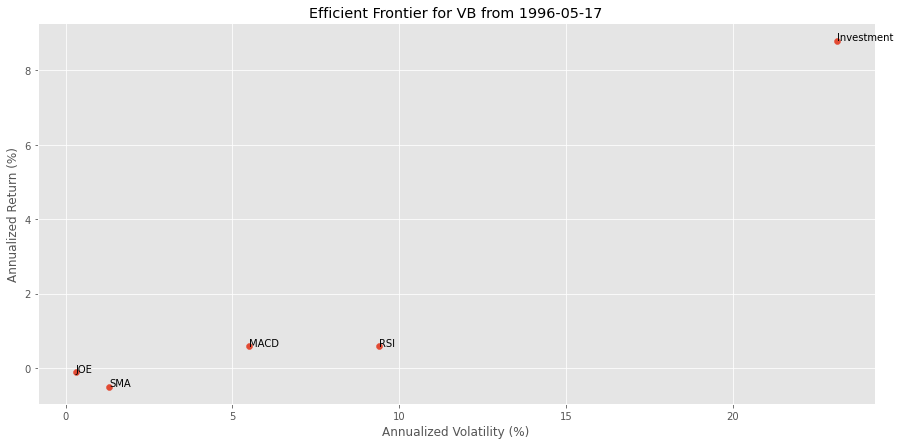

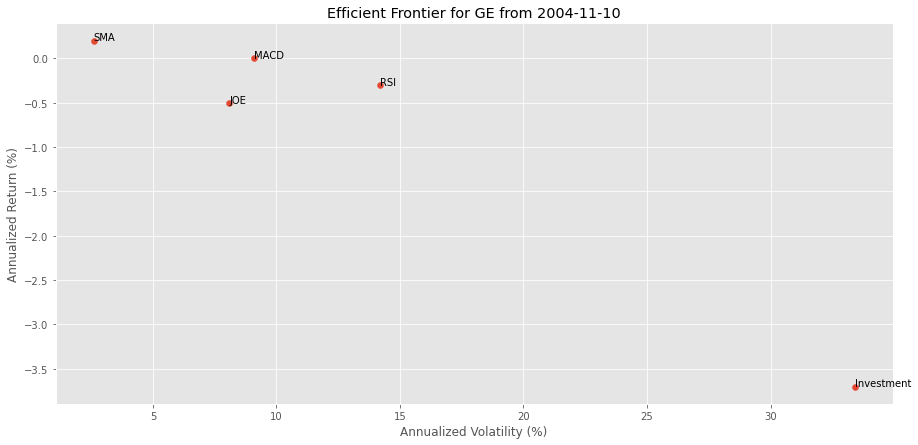

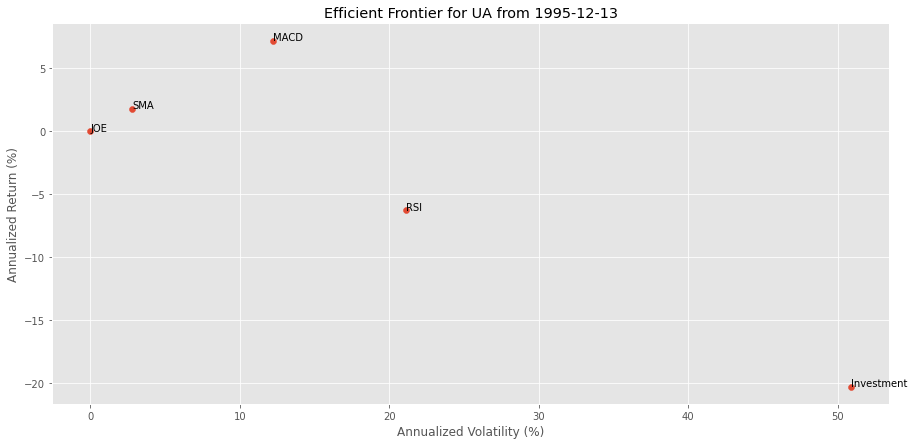

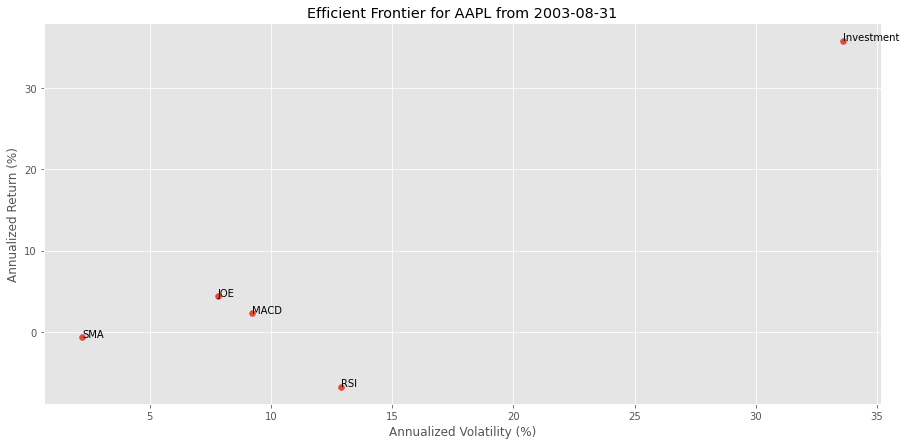

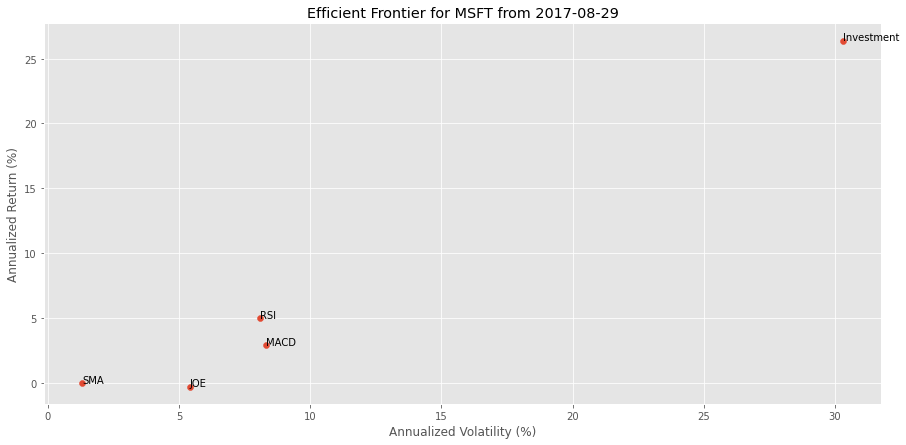

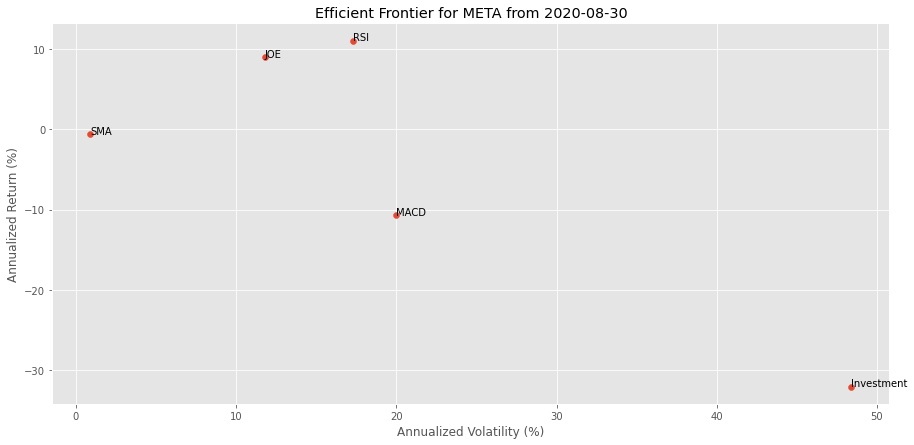

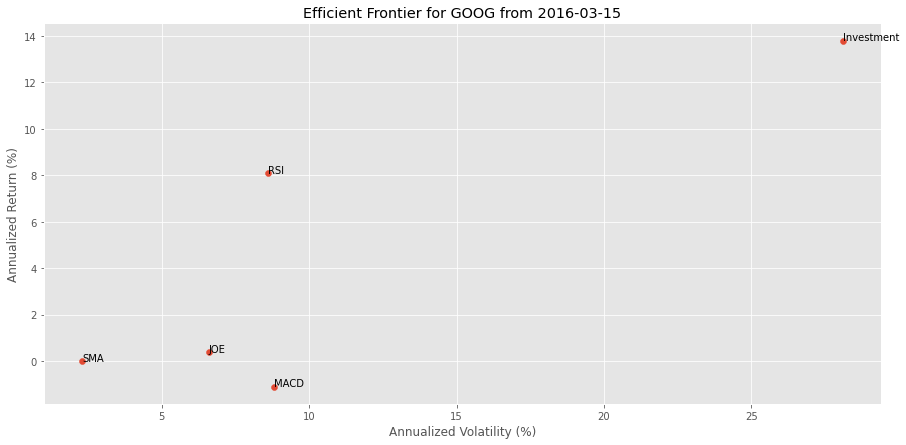

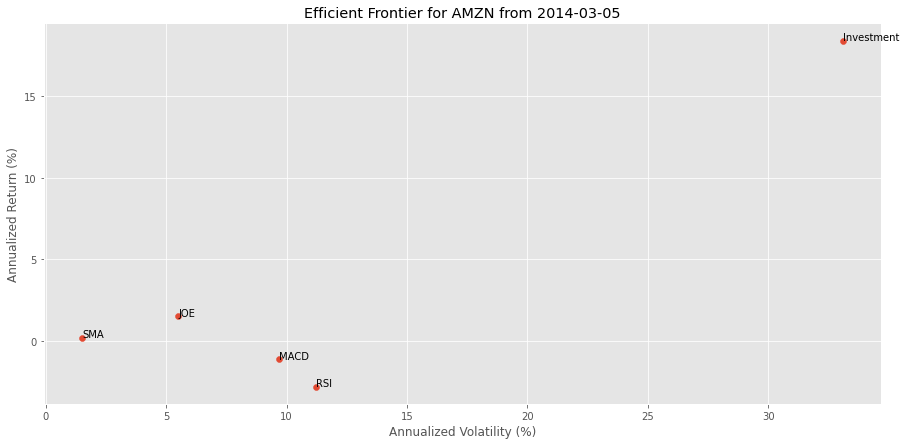

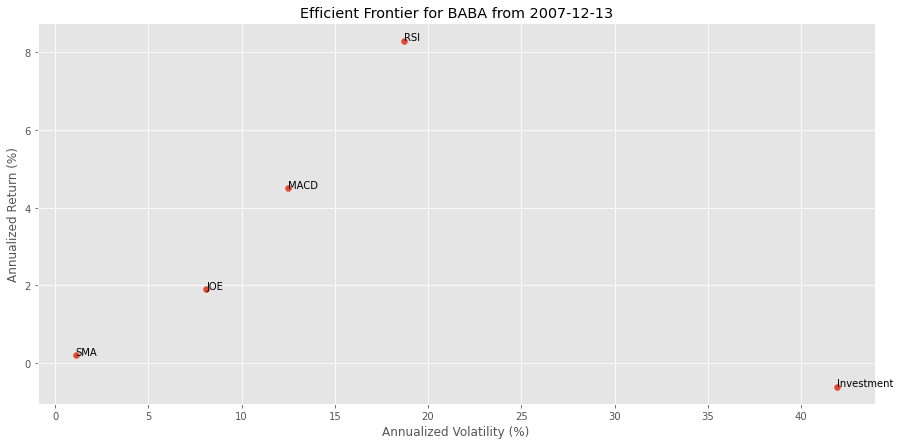

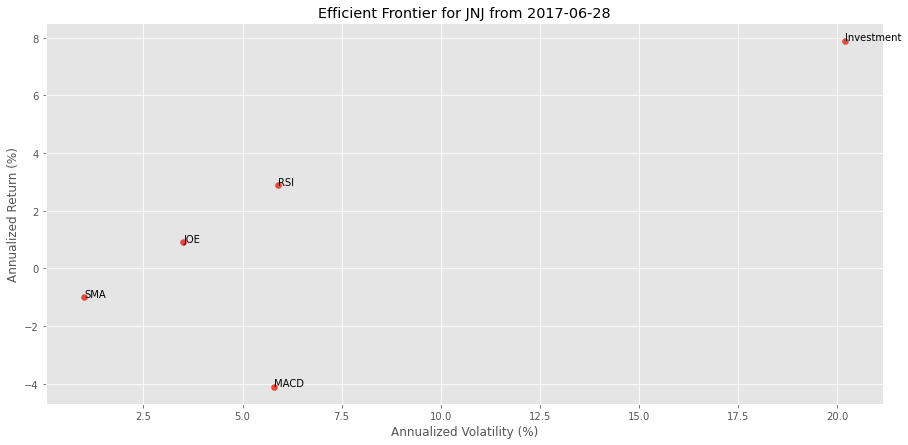

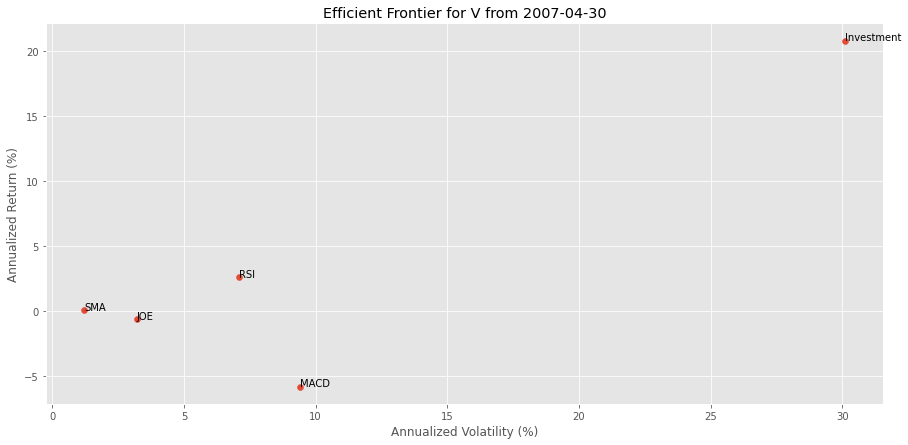

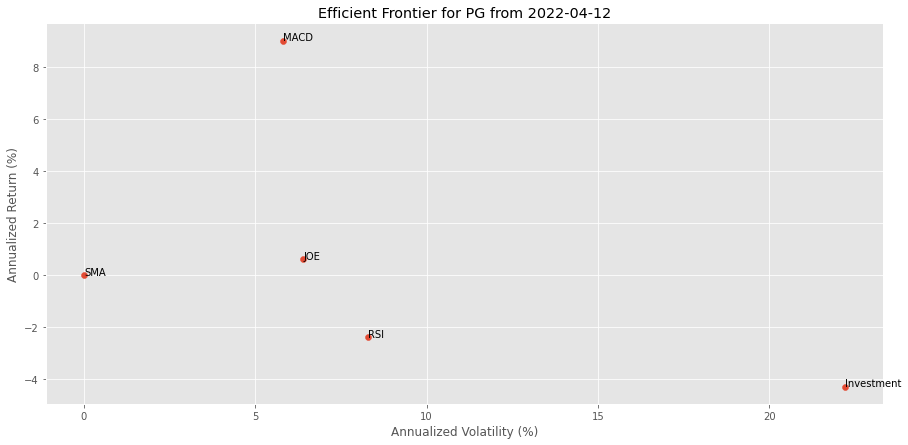

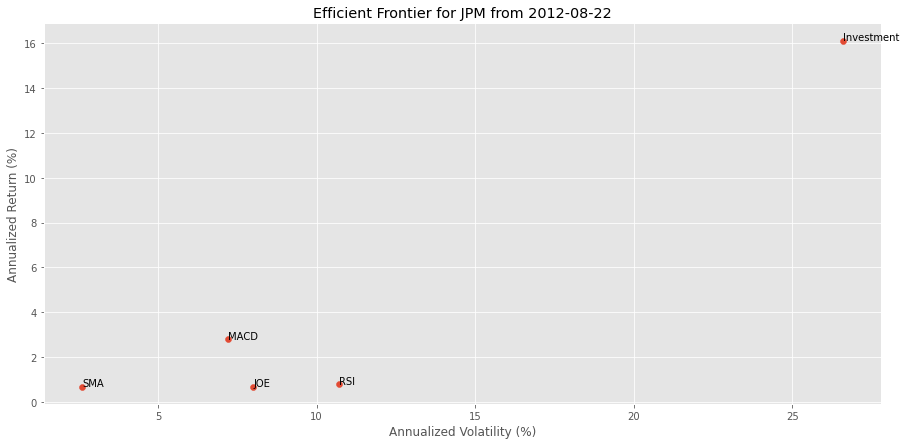

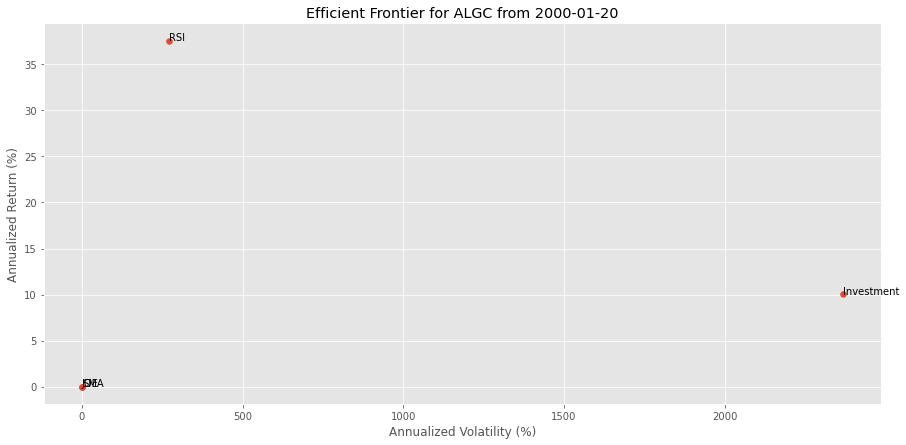

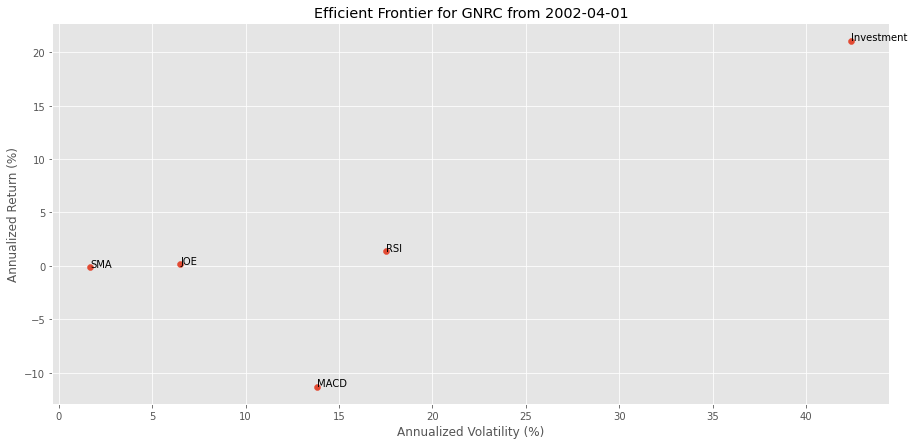

In [6]:
start_date = date.today()
list_of_tickers = ['TSLA', 'VTI', 'VB', 'GE', 'UA', 'AAPL', 'MSFT', 'META',
              'GOOG', 'AMZN', 'BABA', 'JNJ', 'V', 'PG', 'JPM', 'ALGC', 'GNRC']
list_of_strategies = ["MACD", "SMA", "RSI", "JOE"]
tables = []
for ticker in list_of_tickers:
    
    #random.seed(123)
    # Choose a random date within the past 10000 days
    random_day = start_date - timedelta(days=random.randint(0, 10000))
    
    # Create ticker
    locals()[ticker] = Ticker(ticker, str(random_day))
    table = locals()[ticker].sum_table(list_of_strategies)
    table['Strategy'] = locals()[ticker].ticker + " - " + table['Strategy']
    tables.append(table)
    locals()[ticker].efficient_front(list_of_strategies)

In [8]:
combined_table = pd.concat(tables)
combined_table = combined_table.sort_values(by='Annualized Return (%)', ascending=False)
combined_table

,Strategy,Annualized Return (%),Annualized Volatility (%)
0,TSLA - Investment,41.4,57.1
3,ALGC - RSI,37.6,271.1
0,AAPL - Investment,35.8,33.6
0,MSFT - Investment,26.4,30.3
0,GNRC - Investment,21.1,42.4
...,...,...,...
1,GNRC - MACD,-11.3,13.8
3,TSLA - RSI,-14.6,26.5
0,UA - Investment,-20.3,50.9
0,META - Investment,-32.0,48.4


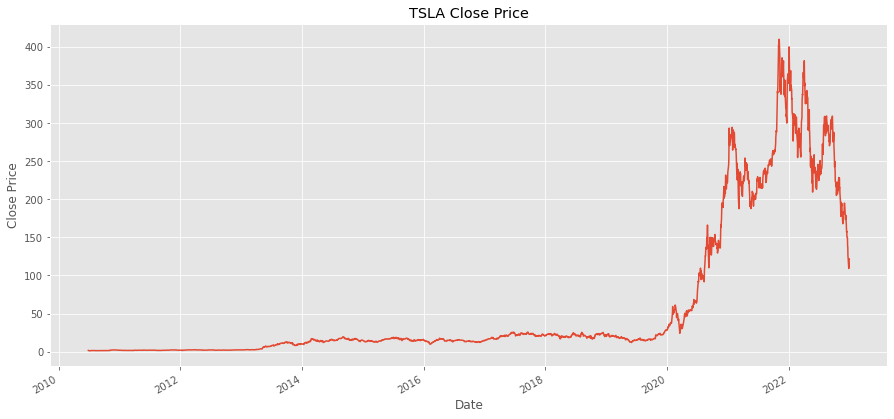

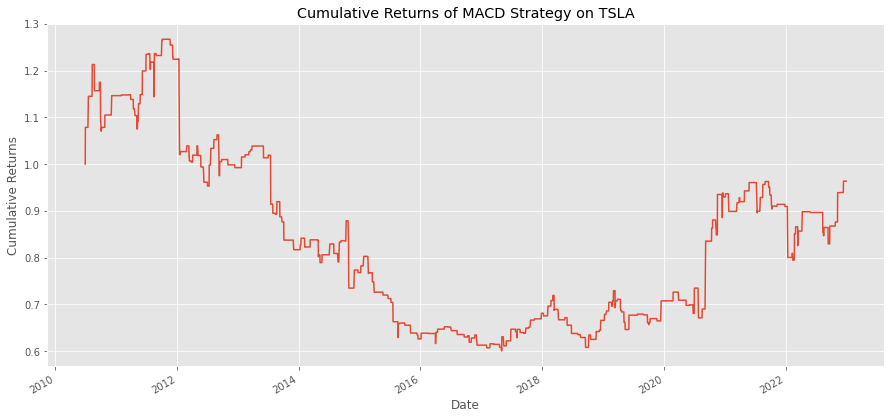

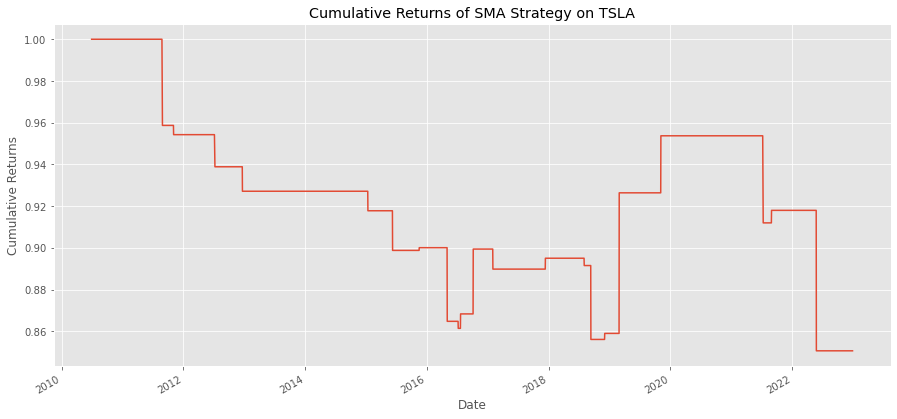

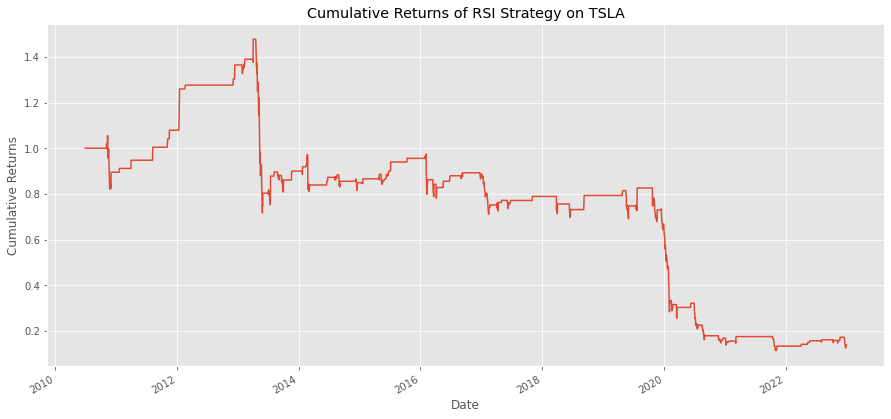

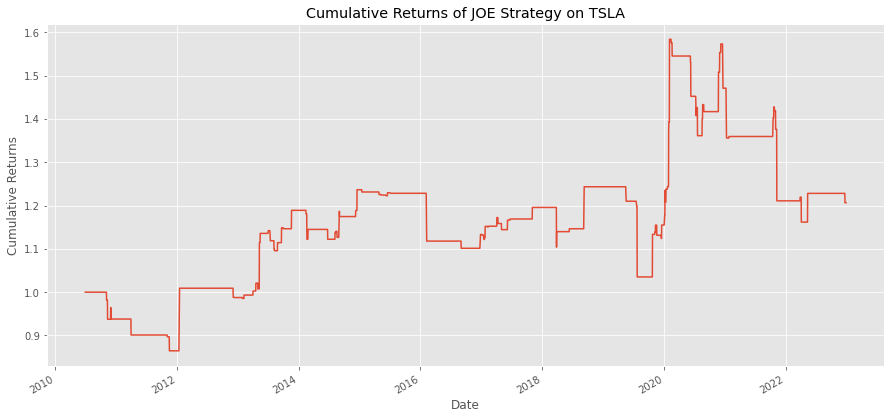

In [9]:
TSLA.sum_vis(["MACD", "SMA", "RSI", "JOE"])